# Analyzing CIA Factbook Data

The goal of this project is to analyze the CIA Factbook Data using sqlite and Python. In this project, we'll work with data from the [CIA World Factbook](https://www.cia.gov/library/publications/the-world-factbook/), a compendium of statistics about all of the countries on Earth. The Factbook contains demographic information like:

* __`population`__ - The population as of 2015
* __`population_growth`__ - The annual population growth rate, as a percentage.
* __`area`__ - The total land and water area

You can download the SQLite database, factbook.db, from this [GitHub repo](https://github.com/factbook/factbook.sql/releases) if you would like to work through yourself.

__Disclaimer:__ This project was developed as part of the guided projects on dataquest. All of the code and analysis here is done by me with some guiding from the dataquest platform.

## Loading Data

In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
# connect to sqlite3 db and check tables
conn = sqlite3.connect('factbook.db')
query = "SELECT * FROM sqlite_master WHERE type='table';"
pd.read_sql_query(query, conn)

,type,name,tbl_name,rootpage,sql
0,table,facts,facts,2,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."
1,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"


Let's look at the first 5 rows of the data.

In [5]:
query = "SELECT * FROM facts LIMIT 5"
pd.read_sql_query(query, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30,2015-11-01 13:19:54.431082,2015-11-01 13:19:54.431082
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92,2015-11-01 13:19:59.961286,2015-11-01 13:19:59.961286
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00,2015-11-01 13:20:03.659945,2015-11-01 13:20:03.659945
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46,2015-11-01 13:20:08.625072,2015-11-01 13:20:08.625072


Here are the descriptions for some of the columns:

* __`name`__ - The name of the country.
* __`area`__ - The total land and sea area of the country.
* __`population`__ - The country's population.
* __`population_growth`__ - The country's population growth as a percentage.
* __`birth_rate`__ - The country's birth rate, or the number of births a year per 1,000 people.
* __`death_rate`__ - The country's death rate, or the number of death a year per 1,000 people.
* __`area`__ - The country's total area (both land and water).
* __`area_land`__ - The country's land area in square kilometers.
* __`area_water`__ - The country's waterarea in square kilometers.

We will start by calculating some of the summary statistics.

## Data Analysis & Simple Visualization

In [6]:
query = "SELECT MIN(population), MAX(population), MIN(population_growth), MAX(population_growth) FROM facts"
pd.read_sql_query(query, conn)

,MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,0,7256490011,0.0,4.02


We observe that there is a country with population 0 and population 7.2 billion people. Let's look at them closer.

In [7]:
query = "SELECT name, population FROM facts WHERE population = (SELECT MIN(population) FROM facts)"
pd.read_sql_query(query, conn)

,name,population
0,Antarctica,0


In [8]:
query = "SELECT name, population FROM facts WHERE population = (SELECT MAX(population) FROM facts)"
pd.read_sql_query(query, conn)

,name,population
0,World,7256490011


It seems the facts table contains 'World' and 'Antarctica' as countries thus our min and max numbers. We will want to ignore these rows and generate our visualizations, specifically histograms. Let's look at all countries and their

* `population`
* `population_growth`
* `birth_rate`
* `death_rate`

C:\Users\kamra\Miniconda3\envs\DSEnvConda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002129E6DB048>,
      dtype=object)

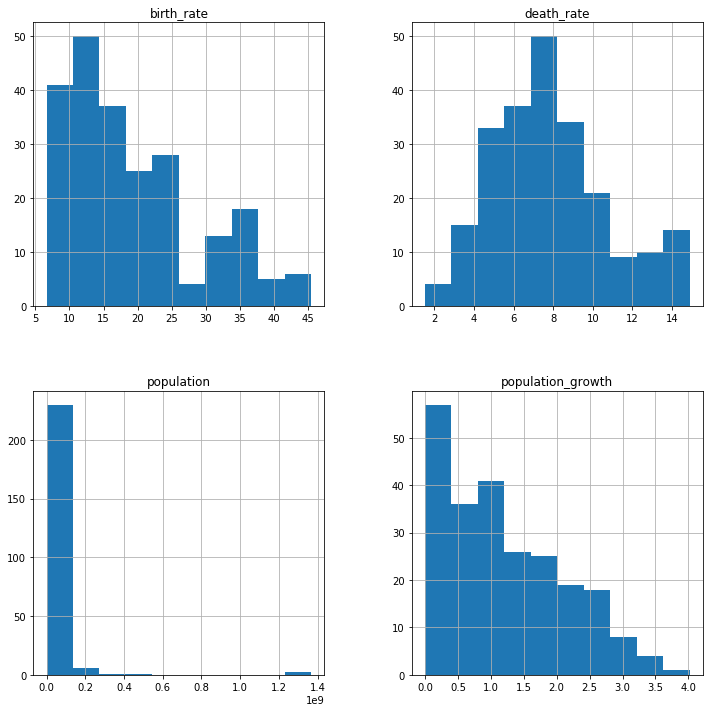

In [9]:
query = "SELECT name, population, population_growth, birth_rate, death_rate FROM facts WHERE name not in ('World', 'Antarctica')"
fig, ax = plt.subplots(figsize=(12, 12))
pd.read_sql_query(query, conn).hist(ax=ax)

We can observe that majority of countries birth rate falls in between 7 to 17 births per year per 1000 people, while the death rate actually is 6 to 10 deaths per year per 1000 people. Majority of countries have a population growth in between 0 to 1 %, while most of the countries have a population up to 200 million. Let's explore further and answer the following questions:

* Which countries have the highest population density?
    * Population density is the ratio of population to land area
* Which countries have the highest ratios of water to land? Which countries have more water than land?

### Question 1

To find out countries with the highest population density we need to basically divide the population by the area and order by the density column. We will only take the top 10 countries with highes population.

,name,density
0,Macau,21168
1,Monaco,15267
2,Singapore,8259
3,Hong Kong,6655
4,Gaza Strip,5191
5,Gibraltar,4876
6,Bahrain,1771
7,Maldives,1319
8,Malta,1310
9,Bermuda,1299


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002129E81A8D0>]],
      dtype=object)

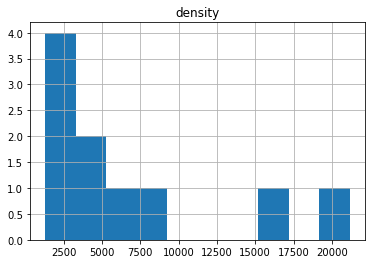

In [10]:
query = "SELECT name, population / area_land AS density FROM facts ORDER BY density desc LIMIT 10"
display(pd.read_sql_query(query, conn))
pd.read_sql_query(query, conn).hist()

We can compare our results with the source [here](https://simple.wikipedia.org/wiki/List_of_countries_by_population_density)

### Question 2

To find out the countries with highest water to land ratio, we simply need to divide the area of the country under water by the total land area.

In [11]:
query = "SELECT area_water / area AS ratio FROM facts ORDER BY ratio DESC LIMIT 10"
pd.read_sql_query(query, conn)

,ratio
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


For some reason the ratio across countries is 0 which should not be the case.